## feeder concept: cutter + barges

This notebook shows how to implement a basic feeder concept for a cutter suction dredge working with multiple barges.

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
from openclsim.utils import flatten, export_concepts, export_activities
from openclsim.plot import get_step_chart, get_gantt_chart, get_log_dataframe, get_ranges_dataframe
import numpy as np

In [2]:
cutter_name    = 'Cutter T'
barge_names    = ['Carrier A','Carrier B','Carrier C',
                  'Barge I','Barge II','Barge III',
                  'Extra 1', 'Extra 2', 'Extra 3']
vessel_cost     = {'Carrier A':6000,'Carrier B':6000,'Carrier C':6000,
                  'Barge I':5000,'Barge II':5000,'Barge III':5000,
                  'Extra 1':4000, 'Extra 2':4000, 'Extra 3':4000,
                  'Cutter T':25000} # EUR/day
# vessel_amount and vessel_durations are random within a range,
# to mimic respectively material density variations
# and metocean workability conditions and traffic density.

amount_range = [4,6]
duration_range = [2000,3000]

from_site_name = 'Trench'
to_site_name   = 'Reclamation'

In [3]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [4]:
def run(NR_BARGES, total_amount, simulation_start=0):
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    
    sites = {}

    data_from_site = {"env": my_env,
                      "name": from_site_name,
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site =  Site(**data_from_site)
    sites[from_site_name] = from_site


    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": to_site_name,
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)
    sites[to_site_name] = to_site

    vessels = {}

    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        vessels[vessel_name] = TransportProcessingResource(
            env=my_env,
            name=vessel_name,
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=cutter_name,
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels[cutter_name] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        amount = np.random.randint(amount_range[0], amount_range[1]) # handle loading
        duration=np.random.randint(duration_range[0], duration_range[1]) # sailing and unloading

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle {vessel_name}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle {vessel_name}",
                registry=registry,
                sub_processes=[
# cannot be linked to a vessel as it is neither mover, processor, origin or destination
#                     model.BasicActivity(
#                         env=my_env,
#                         name=f"basic activity:"+vessels[vessel_name].name,
#                         registry=registry,
#                         duration=duration,
#                         additional_logs=[vessels[vessel_name]],
#                     ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[vessel_name],
                        amount=amount,
                        duration=500*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=vessels[vessel_name],
                        origin=vessels[vessel_name],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        "sites":sites
    }


# Example plots with 3 barges

In [5]:
%%time
nbarges = len(barge_names)
assert len(set(barge_names))==len(barge_names), 'barge_names need to be unique'
total_amount = 100
simulation_start = 0
res = run(3,total_amount, simulation_start)

vessels = res['vessels']
sites = res['sites']
activities = res['activities']

cutter = vessels[cutter_name]
to_site = sites[to_site_name]
from_site = sites[from_site_name]

CPU times: user 55.3 ms, sys: 2.25 ms, total: 57.6 ms
Wall time: 47.7 ms


In [6]:
fig = get_gantt_chart(vessels, id_map=activities)

In [7]:
fig = get_gantt_chart([from_site, to_site, cutter], id_map=activities)

Plot only activities whose namespace (first letters) matches load*

In [8]:
flat = pd.DataFrame(flatten(activities))
loading = list(flat[flat['ActivityName'].str.startswith('loading')]['activity'].values)
fig = get_gantt_chart(loading)

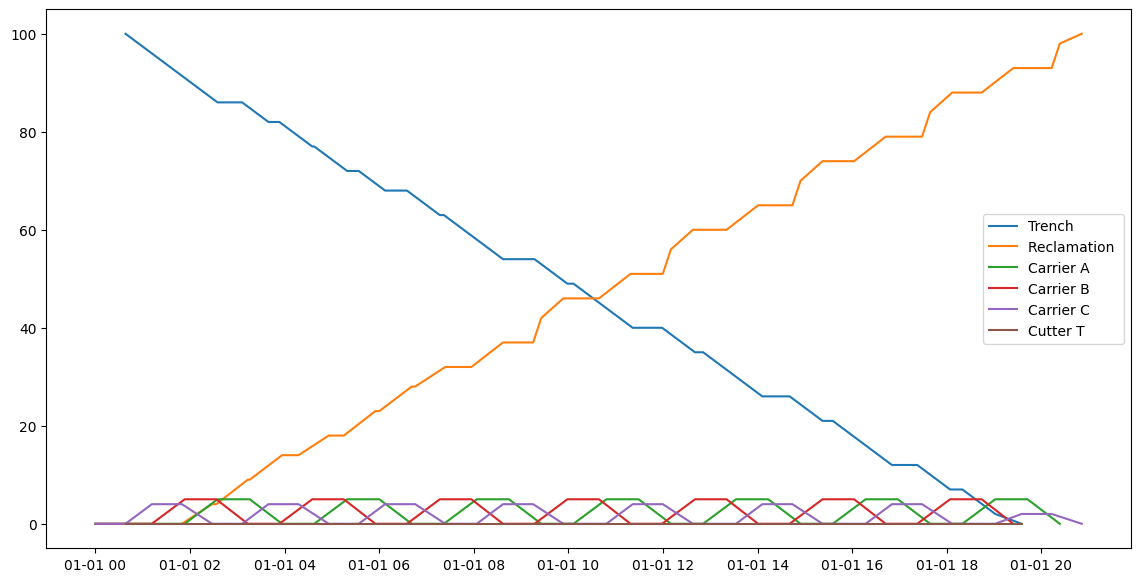

In [9]:
fig = get_step_chart([from_site, to_site, *vessels.values()])

In [10]:
def occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost):
    """Model specific calculation of vessel occupancy"""
    
    data = []
    
    for i, vessel_name in enumerate(vessels):
        vessel = vessels[vessel_name]

        log = get_ranges_dataframe(vessel)
        
        duration_theory = log.TimestampDt.sum().total_seconds()
        
        # We assume all vessels arrive JIT when they need to start,
        # and leaves immediately when they are done (so different demob times)
        # this is an overestimation of actual occupancy
        
        duration_actual = (log.TimestampStop.max() - log.TimestampStart.min()).total_seconds()
        nr_trips = len(log.groupby('trip'))
        
        if vessel.name==cutter_name:
            amount = total_amount
        else:
            amount = sum(log.groupby('trip')['ContainerLevelStop'].max())
        
        data.append({
            'name':vessel.name, 
            '# trips':nr_trips, 
            'start': log.TimestampStart.min(),
            'finish': log.TimestampStop.max(),
            'amount sum': amount,
            'duration actual': duration_actual,
            'duration theory':duration_theory,
            'cost actual':round(duration_actual*vessel_cost[vessel_name]/3600/24,0),
            'production actual':(nr_trips * amount) / (duration_actual),
            'production theory':(nr_trips * amount / (duration_theory)),
        })

    df = pd.DataFrame(data).sort_values(by=['production actual'],ascending=False)
    df['occupancy [%]'] = [round(x,1) for x in 100*df['production actual']/df['production theory']]
    df.set_index('name', inplace=True)
    
    # cutter does amount same as all barges
    assert df['amount sum'].sum()-total_amount==total_amount, 'material imbalance'
    
    return df

In [11]:
occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost).sort_values(by=["name"])

,# trips,start,finish,amount sum,duration actual,duration theory,cost actual,production actual,production theory,occupancy [%]
name,,,,,,,,,,
Carrier A,7,1970-01-01 00:00:00,1970-01-01 20:23:12,35.0,73392.0,69055.0,5097.0,0.003338,0.003548,94.1
Carrier B,7,1970-01-01 00:00:00,1970-01-01 19:24:12,35.0,69852.0,67963.0,4851.0,0.003507,0.003605,97.3
Carrier C,8,1970-01-01 00:00:00,1970-01-01 20:51:06,30.0,75066.0,71008.0,5213.0,0.003197,0.003380,94.6
Cutter T,8,1970-01-01 00:38:12,1970-01-01 19:34:42,100.0,68190.0,51000.0,19731.0,0.011732,0.015686,74.8


# Compare multiple barge scenarios

In [12]:
results = []
occupancy = []
cost = []
duration = []

n_barges = range(2,len(barge_names)) # +1 at least 1 barge
for i in n_barges:
    results.append(run(i,total_amount))
    
    vessels = results[-1]['vessels']
    activities = results[-1]['activities']
    sites = results[-1]['sites']
    
    cutter = vessels[cutter_name]
    
    df = occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost)
    occupancy.append(df.loc[cutter_name]['occupancy [%]'])
    cost.append(df['cost actual'].sum())
    duration.append((df['finish'].max() - df['start'].min()).total_seconds()/3600/24)
    #     display(df)
    
scenarios = {'# barges':n_barges,
             'cutter occupancy':occupancy,
             'total cost':cost,
             'total duration':duration}
scenarios = pd.DataFrame.from_dict(scenarios)
scenarios

,# barges,cutter occupancy,total cost,total duration
0,2,50.5,43032.0,1.236447
1,3,74.6,34145.0,0.844977
2,4,88.2,32418.0,0.742593
3,5,97.9,32630.0,0.685810
4,6,100.0,35108.0,0.665891
5,7,100.0,35698.0,0.649051
6,8,100.0,38591.0,0.676238


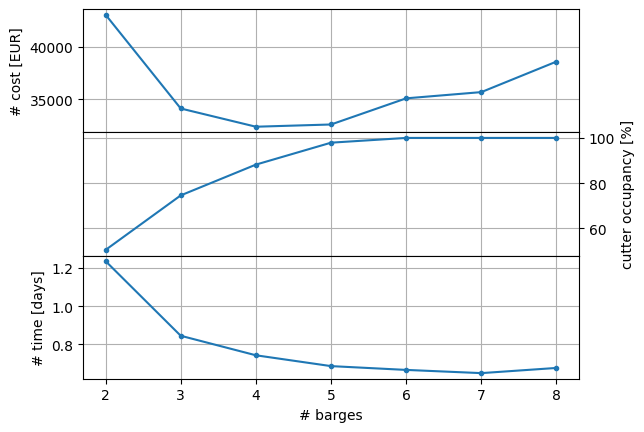

In [13]:
# plot 3 optimization criteria: cost, duration, occupancy (1/flexibility)
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)


axs[0].plot(scenarios['# barges'],scenarios['total cost'],'.-'), axs[0].set_ylabel('# cost [EUR]'),axs[0].grid();
# axs[0].set_xlabel('# barges');

axs[1].plot(scenarios['# barges'],scenarios['cutter occupancy'],'.-'), axs[1].set_ylabel('cutter occupancy [%]'),axs[1].grid();
# axs[1].set_xlabel('# barges');
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].plot(scenarios['# barges'],scenarios['total duration'],'.-'), axs[2].set_ylabel('# time [days]'),axs[2].grid();

axs[-1].set_xlabel('# barges');

In [15]:
# choose 1 scenario for further analysis and export
# many barges: close to 100% cutter config, small cost, fast delivery.
scenario_index = 2

# Visualize critical path of chosen optimal scenario

For explanation of Critical Path see notebook 30

In [16]:
from openclsim.plot.critical_path import CpLog

In [17]:
i = scenario_index
vessels = results[i]['vessels']
activities = results[i]['activities']
sites = results[i]['sites']
  
my_objects = list(vessels.values()) + list(sites.values())
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
dependencies = my_log.get_dependencies_model_based()
# dependencies = my_log.get_dependencies_log_based()
cp = my_log.mark_critical_activities(dependencies)
occupancy = occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost)

t = f'{cutter_name} occupancy: ' + str(occupancy.loc[cutter_name]['occupancy [%]']) + f'duration actual: ' +\
     str(occupancy.loc[cutter_name]['duration actual'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp, id_map=activities, title=t, legend=False, ylabel='vesels')

In [18]:
occupancy

,# trips,start,finish,amount sum,duration actual,duration theory,cost actual,production actual,production theory,occupancy [%]
name,,,,,,,,,,
Cutter T,6,1970-01-01 00:40:32,1970-01-01 16:25:48,100.0,56716.0,50000.0,16411.0,0.010579,0.012000,88.2
Carrier A,6,1970-01-01 00:00:00,1970-01-01 17:05:12,30.0,61512.0,58776.0,4272.0,0.002926,0.003062,95.6
Barge I,6,1970-01-01 00:00:00,1970-01-01 17:49:20,30.0,64160.0,60108.0,3713.0,0.002805,0.002995,93.7
Carrier C,5,1970-01-01 00:00:00,1970-01-01 15:26:17,20.0,55577.0,48310.0,3860.0,0.001799,0.002070,86.9
Carrier B,5,1970-01-01 00:00:00,1970-01-01 16:38:54,20.0,59934.0,53395.0,4162.0,0.001669,0.001873,89.1


# Export data  to BI

In [19]:
export_concepts(sites, 'site', 'sites.csv')

,siteName,siteID,siteType
0,Trench,6ad2b35a-fdd1-42a9-9cf3-b34e62b62a3b,<class '__main__.Site'>
1,Reclamation,b17b67eb-e0d6-4961-92eb-4e7eff511c56,<class '__main__.Site'>


In [20]:
export_concepts(vessels, 'vessel', 'vessels.csv')

,vesselName,vesselID,vesselType
0,Carrier A,76a157f4-89d4-40df-b0f5-4cc27498d2f4,<class '__main__.TransportProcessingResource'>
1,Carrier B,da4a7158-25dc-4ea5-b935-2fa216224bb1,<class '__main__.TransportProcessingResource'>
2,Carrier C,7a3c67d2-ce66-416b-bc40-edd890ea1b6a,<class '__main__.TransportProcessingResource'>
3,Barge I,201d95c4-057e-44e3-85ee-2926772cfb3a,<class '__main__.TransportProcessingResource'>
4,Cutter T,ee775b2e-39d1-4dda-9ed1-07fe48cba975,<class '__main__.TransportProcessingResource'>


In [21]:
activities_flat = export_activities(activities, 'activities.csv', [*sites.values(), *vessels.values()])
# activities_flat

In [22]:
set(activities_flat['MoverName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C'}

In [23]:
set(activities_flat['ProcessorName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C', 'Cutter T'}

In [24]:
set(activities_flat['OriginName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C', 'Trench'}

In [25]:
set(activities_flat['DestinationName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C', 'Reclamation', 'Trench'}

In [26]:
set(activities_flat['ActivityType'])

{'MoveActivity', 'SequentialActivity', 'ShiftAmountActivity', 'WhileActivity'}

In [27]:
# set(activities_flat['ActivityName'])

# Expand logged activity instances to analyse occupancy properly

In [28]:
def export_ranges(all_act_flat, ofile = None, concept_name=None):
    
    if concept_name:
        logmask = (all_act_flat['ProcessorName']==concept_name) | \
                  (all_act_flat['MoverName']==concept_name)  | \
                  (all_act_flat['OriginName']==concept_name)  | \
                  (all_act_flat['DestinationName']==concept_name) 

        all_act_flat = all_act_flat[logmask]
    
    li = []
    for i, rowi in all_act_flat.iterrows():
        log = get_ranges_dataframe(rowi['activity'])
        log.rename(columns={'Activity':'ActivityID'}, inplace=True)
        li.append(log)
    ActivityRanges = pd.concat(li)
    
    ActivityRanges = ActivityRanges.merge(all_act_flat[['ActivityID', 'ActivityName', 'ActivityType']], on='ActivityID', how='left')
    
    keys  = ['trip',
             'ActivityID','ActivityName','ActivityType',
             'TimestampStart','TimestampStop','TimestampDt']
    if concept_name:
        ActivityRanges['ConceptName'] = concept_name
        keys+=['ConceptName']
        
    if ofile:
        ActivityRanges.to_csv(ofile, columns = keys, index=False)
    
    return ActivityRanges.sort_values(by=["TimestampStart"])

In [29]:
VesselActivitiesLog = export_ranges(activities_flat, 'instances.csv')

In [30]:
VesselActivitiesLog = export_ranges(activities_flat, 'instances_cutter.csv', cutter_name)
VesselActivitiesLog

,TimestampStart,trip,TimestampStop,ActivityID,TimestampDt,ActivityName,ActivityType,ConceptName
0,1970-01-01 00:40:32,1,1970-01-01 01:22:12,dfd86c70-d211-4c64-9e64-95bb075b2613,0 days 00:41:40,loading:Carrier A,ShiftAmountActivity,Cutter T
16,1970-01-01 01:22:12,1,1970-01-01 02:03:52,1af6c98e-3c61-4593-9cdc-ec3a7186dcb9,0 days 00:41:40,loading:Barge I,ShiftAmountActivity,Cutter T
11,1970-01-01 02:03:52,1,1970-01-01 02:37:12,8e9a40da-4df7-4797-b03a-08e7b4eac9ef,0 days 00:33:20,loading:Carrier C,ShiftAmountActivity,Cutter T
6,1970-01-01 02:37:12,1,1970-01-01 03:10:32,c6e38481-24b3-428b-8efc-abc1ef41164b,0 days 00:33:20,loading:Carrier B,ShiftAmountActivity,Cutter T
1,1970-01-01 03:23:48,2,1970-01-01 04:05:28,dfd86c70-d211-4c64-9e64-95bb075b2613,0 days 00:41:40,loading:Carrier A,ShiftAmountActivity,Cutter T
17,1970-01-01 04:09:10,2,1970-01-01 04:50:50,1af6c98e-3c61-4593-9cdc-ec3a7186dcb9,0 days 00:41:40,loading:Barge I,ShiftAmountActivity,Cutter T
12,1970-01-01 04:50:50,2,1970-01-01 05:24:10,8e9a40da-4df7-4797-b03a-08e7b4eac9ef,0 days 00:33:20,loading:Carrier C,ShiftAmountActivity,Cutter T
7,1970-01-01 05:35:11,2,1970-01-01 06:08:31,c6e38481-24b3-428b-8efc-abc1ef41164b,0 days 00:33:20,loading:Carrier B,ShiftAmountActivity,Cutter T
2,1970-01-01 06:08:31,3,1970-01-01 06:50:11,dfd86c70-d211-4c64-9e64-95bb075b2613,0 days 00:41:40,loading:Carrier A,ShiftAmountActivity,Cutter T
18,1970-01-01 06:56:08,3,1970-01-01 07:37:48,1af6c98e-3c61-4593-9cdc-ec3a7186dcb9,0 days 00:41:40,loading:Barge I,ShiftAmountActivity,Cutter T


In [31]:
flat = pd.DataFrame(flatten(activities))
loading = list(flat[flat['ActivityName'].str.startswith('loading')]['activity'].values)
fig = get_gantt_chart(loading)